# 1. Data-Pre-Processing

## Library Import

In [1]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

# For handling Excel files
import openpyxl

# For progress bars
from tqdm.notebook import tqdm

# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline


## Directory

In [2]:
import os

# Define the base directory
base_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))


Contents of the base directory:
['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


## Metadata

In [3]:
import glob

# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))



Found Metadata Files:
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
COVID.metadata.xlsx
Viral Pneumonia.metadata.xlsx


## Four Class and total entries

In [4]:
import pandas as pd
import os

root_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize a dictionary to hold metadata DataFrames
metadata = {}

for cls in classes:
    # Special case for 'Viral Pneumonia'
    if cls == 'Viral Pneumonia':
        metadata_path = os.path.join(root_dir, 'Viral Pneumonia.metadata.xlsx')
    else:
        metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx')
        
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")


Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [5]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [6]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_mask_pairs, transform=None, mask_transform=None):
        """
        Args:
            image_mask_pairs (list of tuples): List where each tuple contains (image_path, mask_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_path, mask_path, label = self.image_mask_pairs[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Load mask
        mask = Image.open(mask_path).convert('L')      # Grayscale for masks
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask, label


In [7]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define mask transformations (only resizing and tensor conversion)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
# Define the root directory of the dataset
root_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}


In [9]:
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to masks
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    masks_dir = os.path.join(root_dir, cls, 'masks')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        mask_path = os.path.join(masks_dir, img_filename)  # Assuming mask has same filename
        
        # Check if mask exists
        if os.path.exists(mask_path):
            all_mapped_data.append((img_path, mask_path, label_mapping[cls]))
        else:
            print(f"Mask not found for image: {img_path}")


In [10]:
# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'mask_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")


Mapped DataFrame:


,image_path,mask_path,label
0,/kaggle/input/covid19-radiography-database/COV...,/kaggle/input/covid19-radiography-database/COV...,0
1,/kaggle/input/covid19-radiography-database/COV...,/kaggle/input/covid19-radiography-database/COV...,0
2,/kaggle/input/covid19-radiography-database/COV...,/kaggle/input/covid19-radiography-database/COV...,0
3,/kaggle/input/covid19-radiography-database/COV...,/kaggle/input/covid19-radiography-database/COV...,0
4,/kaggle/input/covid19-radiography-database/COV...,/kaggle/input/covid19-radiography-database/COV...,0


Total images mapped: 21165


In [11]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")


Total samples: 21165
Training samples: 14815
Validation samples: 3174
Testing samples: 3176


In [12]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[2] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[2] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")


Training samples: 14815
Validation samples: 3175
Testing samples: 3175


In [13]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[2] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [14]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform, mask_transform=mask_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform, mask_transform=mask_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform, mask_transform=mask_transform)

# Define batch size and number of workers
batch_size = 32
num_workers = 4  # Adjust based on your Kaggle kernel's CPU cores

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


Number of batches - Train: 463, Val: 100, Test: 100


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


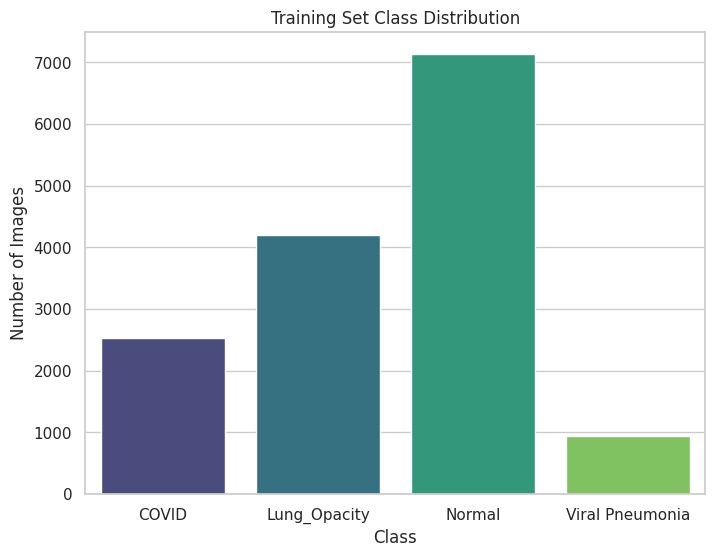

In [15]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


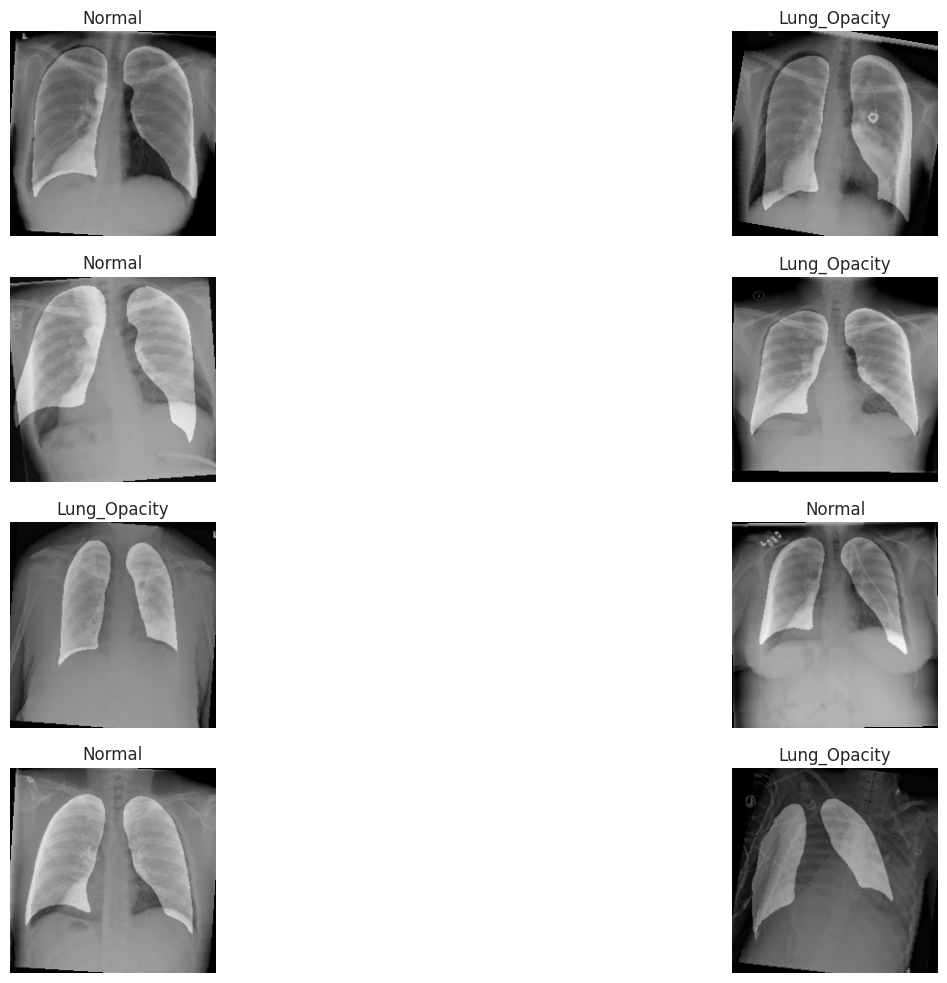

In [16]:
def imshow(img, title=None):
    """
    Displays a tensor as an image.
    
    Args:
        img (Tensor): Image tensor.
        title (str, optional): Title for the image.
    """
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                 np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_batch(loader, classes, num_images=8):
    """
    Displays a batch of images with their masks and labels.
    
    Args:
        loader (DataLoader): DataLoader to fetch the batch.
        classes (list): List of class names.
        num_images (int): Number of images to display.
    """
    images, masks, labels = next(iter(loader))
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, num_images//4, i+1)
        imshow(images[i])
        mask = masks[i].squeeze().numpy()
        plt.imshow(mask, cmap='gray', alpha=0.3)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch from the training set
show_batch(train_loader, classes, num_images=8)


In [17]:
class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Baseline, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet(x)
        return x


In [18]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResNet50WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithSE, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.se = SEBlock(channel=2048, reduction=16)  # ResNet50's final conv layer has 2048 channels
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.se(x)  # Apply SE block
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [19]:
import torch
import torch.nn as nn
from torchvision import models

class ECAAttention(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super(ECAAttention, self).__init__()
        t = int(abs((torch.log2(torch.tensor([channels], dtype=torch.float32)) + b) / gamma))
        k = t if t % 2 else t + 1  # Ensure k is odd
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        y = self.avg_pool(x).view(batch_size, channels, 1)
        y = self.conv(y.transpose(1, 2)).transpose(1, 2)
        y = self.sigmoid(y).view(batch_size, channels, 1, 1)
        return x * y.expand_as(x)

class ResNet50WithECA(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithECA, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.eca = ECAAttention(channels=2048)  # ResNet50's final block has 2048 channels
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.eca(x)  # Apply ECA block
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x



In [20]:
import torch
import torch.nn as nn

class GCTBlock(nn.Module):
    def __init__(self, in_channels, epsilon=1e-5, use_relu=True):
        super(GCTBlock, self).__init__()
        self.alpha = nn.Parameter(torch.ones(1, in_channels, 1, 1))
        self.gamma = nn.Parameter(torch.zeros(1, in_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, in_channels, 1, 1))
        self.epsilon = epsilon
        self.use_relu = use_relu

    def forward(self, x):
        # L2 norm computation
        norm = torch.sqrt(x.pow(2).mean(dim=(2, 3), keepdim=True) + self.epsilon)
        y = self.alpha * x / norm
        
        # Apply ReLU if specified
        if self.use_relu:
            y = nn.functional.relu(y)
        
        gate = 1. + torch.tanh(self.gamma * y + self.beta)
        return x * gate

class ResNet50WithGCT(nn.Module):
    def __init__(self, num_classes=4, pretrained=False):
        super(ResNet50WithGCT, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.gct_block = GCTBlock(in_channels=2048)  # Apply GCT after layer4

        # Modify the fully connected layer for the specified number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Apply ResNet layers up to layer4
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        # Apply GCT block
        x = self.gct_block(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [21]:
import torch
import torch.fft as fft
import torch.nn as nn
import torchvision.models as models

class FcaNetBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(FcaNetBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = fft.fft2(x)  # Apply FFT
        y = torch.abs(y).mean(dim=(2, 3), keepdim=True)  # Frequency domain pooling
        y = self.fc(y.view(x.size(0), -1)).view(x.size(0), x.size(1), 1, 1)
        return x * y.expand_as(x)

class ResNet50WithFcaNet(nn.Module):
    def __init__(self, num_classes=4, pretrained=False):
        super(ResNet50WithFcaNet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Apply FCA block after layer4
        self.resnet.layer4 = nn.Sequential(
            self.resnet.layer4,
            FcaNetBlock(in_channels=2048)
        )

        # Set up the final fully connected layer based on `num_classes`
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


In [22]:
class DIANetBlock(nn.Module):
    def __init__(self, in_channels):
        super(DIANetBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
        return x * y

class ResNet50WithDIANet(nn.Module):
    def __init__(self, pretrained=False):
        super(ResNetDIANet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.dianet_block = DIANetBlock(in_channels=2048)  # After layer4

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 4)  # 4 classes

    def forward(self, x):
        x = self.resnet(x)
        x = self.dianet_block(x)  # Apply DIANet Block
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def make_divisible(v, divisor=8, min_value=None, round_limit=0.9):
    min_value = min_value or divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < round_limit * v:
        new_v += divisor
    return new_v

class RadixSoftmax(nn.Module):
    def __init__(self, radix, cardinality):
        super(RadixSoftmax, self).__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

class SplitAttn(nn.Module):
    """Split-Attention (Splat)"""
    def __init__(self, in_channels, out_channels=None, kernel_size=3, stride=1, padding=None,
                 dilation=1, groups=1, radix=2, rd_ratio=0.25, rd_channels=None, rd_divisor=8,
                 act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super(SplitAttn, self).__init__()
        out_channels = out_channels or in_channels
        self.radix = radix
        mid_channels = out_channels * radix
        if rd_channels is None:
            attn_channels = make_divisible(in_channels * radix * rd_ratio, min_value=32, divisor=rd_divisor)
        else:
            attn_channels = rd_channels * radix

        padding = kernel_size // 2 if padding is None else padding
        self.conv = nn.Conv2d(
            in_channels, mid_channels, kernel_size, stride, padding, dilation,
            groups=groups * radix, bias=False)
        self.bn0 = norm_layer(mid_channels)
        self.act0 = act_layer()
        self.fc1 = nn.Conv2d(out_channels, attn_channels, 1, groups=groups, bias=False)
        self.bn1 = norm_layer(attn_channels)
        self.act1 = act_layer()
        self.fc2 = nn.Conv2d(attn_channels, mid_channels, 1, groups=groups, bias=False)
        self.rsoftmax = RadixSoftmax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn0(x)
        x = self.act0(x)

        batch, channels, height, width = x.shape
        if self.radix > 1:
            x = x.view(batch, self.radix, channels // self.radix, height, width)
            x_gap = x.sum(dim=1)
        else:
            x_gap = x
        x_gap = F.adaptive_avg_pool2d(x_gap, 1)
        x_gap = self.fc1(x_gap)
        x_gap = self.bn1(x_gap)
        x_gap = self.act1(x_gap)
        x_attn = self.fc2(x_gap)
        x_attn = self.rsoftmax(x_attn).view(batch, -1, 1, 1)
        
        if self.radix > 1:
            out = (x * x_attn.view(batch, self.radix, channels // self.radix, 1, 1)).sum(dim=1)
        else:
            out = x * x_attn
        return out

class ResNet50WithSplitAttention(nn.Module):
    def __init__(self, num_classes=4, pretrained=False):
        super(ResNet50WithSplitAttention, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Apply Split-Attention block after layer4
        self.resnet.layer4 = nn.Sequential(
            self.resnet.layer4,
            SplitAttn(in_channels=2048)  # Adjusted for 2048 input channels
        )

        # Set up the final fully connected layer for classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


In [24]:
# Define model type options: 'baseline', 'se', 'eca', 'gct', 'fcanet', 'dianet'
model_type = 'gct'  # Options: 'baseline', 'se', 'eca', 'gct', 'fcanet', 'dianet'

# Number of classes
num_classes = len(classes)

# Model selection based on model_type
if model_type == 'baseline':
    model = ResNet50Baseline(num_classes=num_classes)
elif model_type == 'se':
    model = ResNet50WithSE(num_classes=num_classes)
elif model_type == 'eca':
    model = ResNet50WithECA(num_classes=num_classes)
elif model_type == 'gct':
    model = ResNet50WithGCT(num_classes=num_classes)
elif model_type == 'fcanet':
    model = ResNet50WithFcaNet(num_classes=num_classes)
elif model_type == 'dianet':
    model = ResNet50WithDIANet(num_classes=num_classes)
elif model_type == 'splitattn':
    model = ResNet50WithSplitAttention(num_classes=num_classes)
else:
    raise ValueError("Invalid model type selected.")

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50WithGCT(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [25]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [26]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, masks, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [27]:
# Define number of epochs
num_epochs = 25

# Train the model
trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.9461 Acc: 0.5465


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.8180 Acc: 0.5553

Epoch 2/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.7188 Acc: 0.6547


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.7084 Acc: 0.6356

Epoch 3/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.6173 Acc: 0.7147


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.5287 Acc: 0.7732

Epoch 4/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.5422 Acc: 0.7551


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.4438 Acc: 0.7950

Epoch 5/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.4802 Acc: 0.7821


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.5038 Acc: 0.7235

Epoch 6/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.4521 Acc: 0.7943


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.3719 Acc: 0.8413

Epoch 7/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.4243 Acc: 0.8044


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.4960 Acc: 0.7178

Epoch 8/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.3849 Acc: 0.8236


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.3925 Acc: 0.7943

Epoch 9/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.3627 Acc: 0.8382


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.4011 Acc: 0.8094

Epoch 10/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.3490 Acc: 0.8433


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.3510 Acc: 0.8627

Epoch 11/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2680 Acc: 0.8796


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2582 Acc: 0.8876

Epoch 12/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2392 Acc: 0.8871


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2423 Acc: 0.8976

Epoch 13/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2331 Acc: 0.8936


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2369 Acc: 0.8954

Epoch 14/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2276 Acc: 0.8986


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2290 Acc: 0.8917

Epoch 15/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2122 Acc: 0.9033


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2239 Acc: 0.8998

Epoch 16/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2117 Acc: 0.9017


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2236 Acc: 0.8951

Epoch 17/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.2100 Acc: 0.9024


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2213 Acc: 0.9052

Epoch 18/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1994 Acc: 0.9089


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2195 Acc: 0.9011

Epoch 19/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1912 Acc: 0.9131


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2217 Acc: 0.8951

Epoch 20/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1901 Acc: 0.9082


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2211 Acc: 0.9121

Epoch 21/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1745 Acc: 0.9165


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2141 Acc: 0.9121

Epoch 22/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1709 Acc: 0.9199


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2111 Acc: 0.9115

Epoch 23/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1760 Acc: 0.9172


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2111 Acc: 0.9118

Epoch 24/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1705 Acc: 0.9201


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2089 Acc: 0.9121

Epoch 25/25
----------


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Train Loss: 0.1767 Acc: 0.9189


Val:   0%|          | 0/100 [00:00<?, ?it/s]

Val Loss: 0.2124 Acc: 0.9106

Best Validation Acc: 0.9121


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, masks, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Testing:   0%|          | 0/100 [00:00<?, ?it/s]

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.92      0.93      0.93       542
   Lung_Opacity       0.87      0.91      0.89       902
         Normal       0.95      0.91      0.93      1529
Viral Pneumonia       0.93      0.99      0.96       202

       accuracy                           0.92      3175
      macro avg       0.92      0.94      0.93      3175
   weighted avg       0.92      0.92      0.92      3175



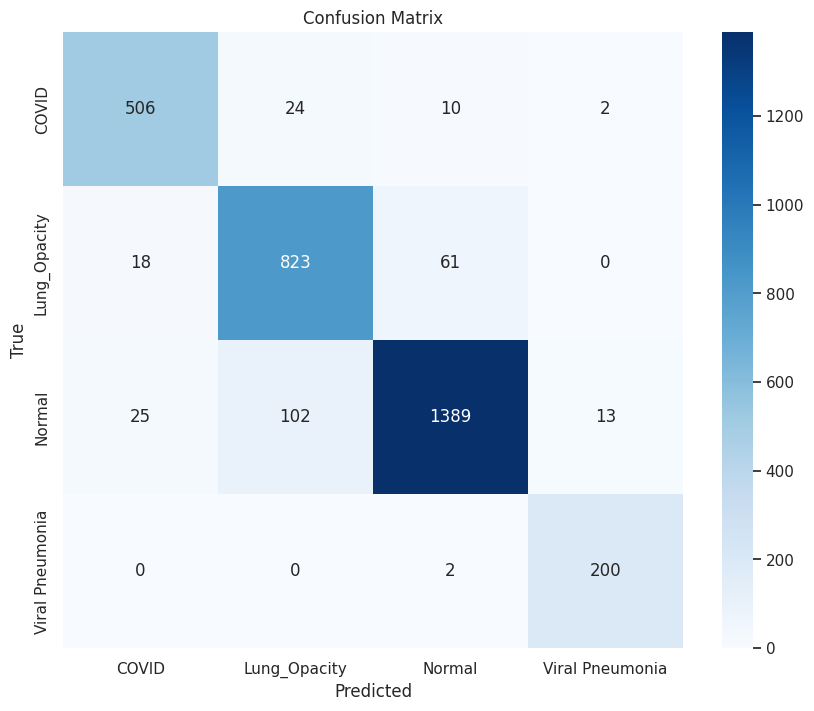

In [29]:

# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)


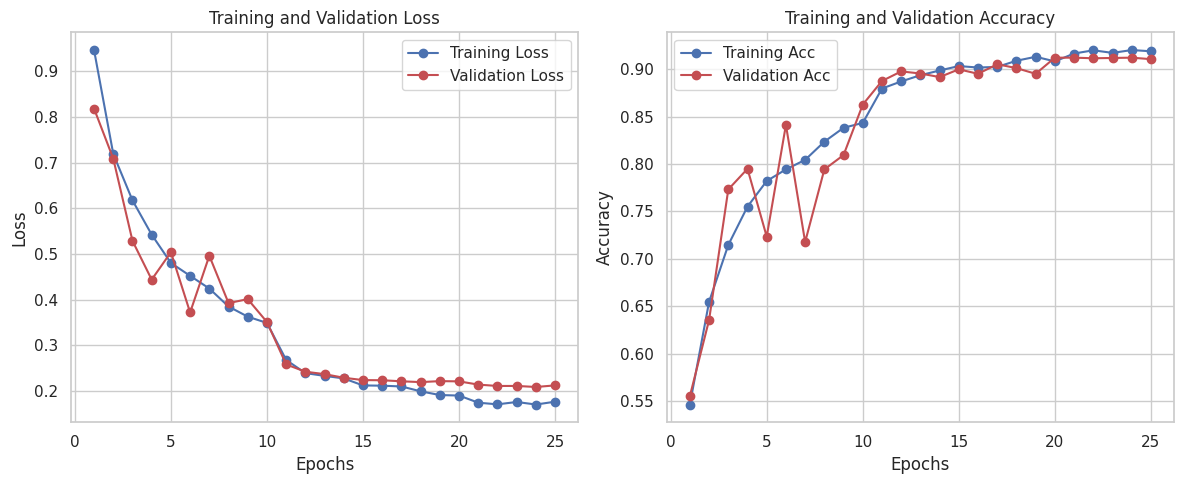

In [30]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


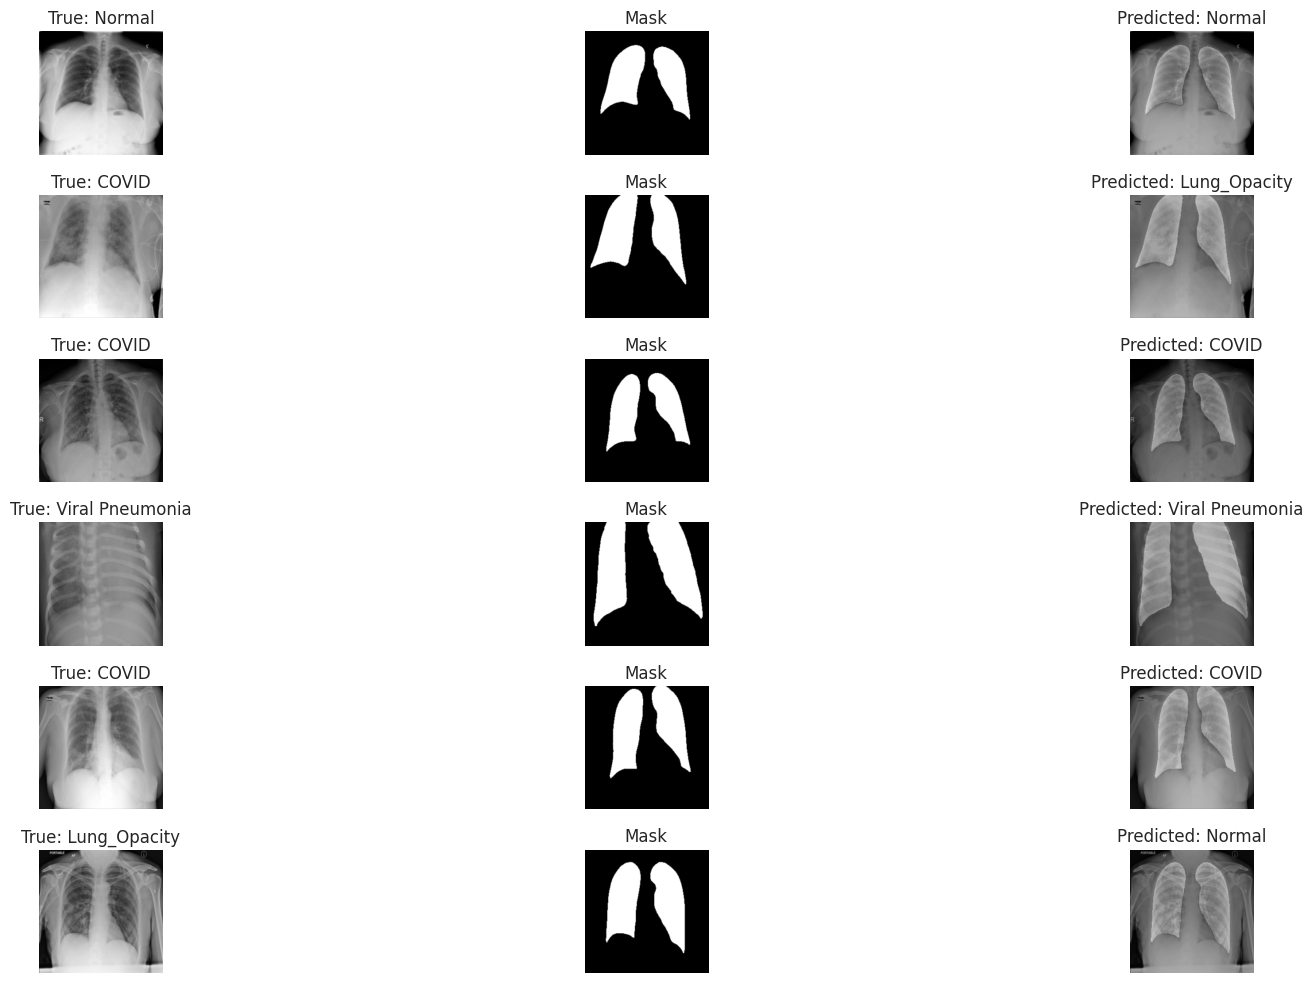

In [31]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, masks, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, 3*i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                     np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}")
        plt.axis('off')
        
        # Mask
        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(img)
        plt.imshow(masks[i].squeeze(), cmap='gray', alpha=0.3)
        plt.title(f"Predicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(trained_model, test_loader, classes, num_images=6)
